# BEST CITY TO ALLOCATE A GAMING COMPANY

## Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import math
import os
from dotenv import load_dotenv

from pymongo import MongoClient

import geopandas as gpd
from geopy.distance import distance
from geopy.distance import geodesic 
from shapely.geometry import Point
from geopy.distance import great_circle
from descartes import PolygonPatch

import matplotlib.pyplot as plt
%matplotlib inline

from cartoframes.viz import Map, Layer
from cartoframes.viz.helpers import size_continuous_layer
from cartoframes.viz.widgets import histogram_widget

import folium
from folium import plugins
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


## MongoDB

In [2]:
#Importing companies.json from mongodb.
client = MongoClient("mongodb://localhost/companies")
db = client.get_database()

In [3]:
#Importing information about companies from MongoDB.
query={"$and":[{"category_code":{"$eq":"games_video"}},{"number_of_employees":{"$gte":10}}]}
list_companies=list(db['companies'].find((query),{"category_code":1,'number_of_employees':1,'name':1,"total_money_raised":1,"offices":1,'_id':0}).sort("number_of_employees",-1))

In [4]:
#Converting the info into 'pandas'
df = pd.DataFrame(list_companies)

In [5]:
#Removing duplicates.
df = df.drop_duplicates(subset='name', keep='first')

In [6]:
#Removing the NAN values from offices column.
df.dropna(subset=['offices'], inplace=True)

In [7]:
df

,name,category_code,number_of_employees,total_money_raised,offices
0,Comcast,games_video,100000,$725M,"[{'description': 'One Comcast Center', 'addres..."
1,The Walt Disney Company,games_video,25000,$0,"[{'description': None, 'address1': '500 S. Bue..."
2,Nintendo,games_video,5080,$0,"[{'description': None, 'address1': None, 'addr..."
3,DeNA,games_video,2192,¥2.21B,"[{'description': 'Headquarters', 'address1': '..."
5,Netflix,games_video,2000,$230M,"[{'description': None, 'address1': '100 Winche..."
...,...,...,...,...,...
232,ToonUps,games_video,10,$0,"[{'description': 'Corporate', 'address1': '11 ..."
233,BIT TV,games_video,10,$0,"[{'description': 'Main Office', 'address1': '4..."
234,Campus Jerk,games_video,10,$0,[]
235,ekidnaworld,games_video,10,$0,"[{'description': '', 'address1': 'Fortitude Va..."


In [8]:
#Removing the lists from offices column 
df = df.explode('offices')
df

,name,category_code,number_of_employees,total_money_raised,offices
0,Comcast,games_video,100000,$725M,"{'description': 'One Comcast Center', 'address..."
1,The Walt Disney Company,games_video,25000,$0,"{'description': None, 'address1': '500 S. Buen..."
2,Nintendo,games_video,5080,$0,"{'description': None, 'address1': None, 'addre..."
3,DeNA,games_video,2192,¥2.21B,"{'description': 'Headquarters', 'address1': 'S..."
5,Netflix,games_video,2000,$230M,"{'description': None, 'address1': '100 Winches..."
...,...,...,...,...,...
232,ToonUps,games_video,10,$0,"{'description': 'Corporate', 'address1': '11 W..."
233,BIT TV,games_video,10,$0,"{'description': 'Main Office', 'address1': '47..."
234,Campus Jerk,games_video,10,$0,NaN
235,ekidnaworld,games_video,10,$0,"{'description': '', 'address1': 'Fortitude Val..."


In [9]:
exapand_office_column = df[["offices"]].apply(lambda r: r.offices, result_type="expand", axis=1)
data_expanded = pd.concat([df,exapand_office_column], axis=1)
data_expanded.head()

,name,category_code,number_of_employees,total_money_raised,offices,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude
0,Comcast,games_video,100000,$725M,"{'description': 'One Comcast Center', 'address...",One Comcast Center,1701 JFK Blvd,,19103,Philadelphia,PA,USA,39.952576,-75.165252
1,The Walt Disney Company,games_video,25000,$0,"{'description': None, 'address1': '500 S. Buen...",None,500 S. Buena Vista St.,,91521,Burbank,CA,USA,34.156802,-118.324987
2,Nintendo,games_video,5080,$0,"{'description': None, 'address1': None, 'addre...",None,None,None,None,None,None,JPN,36.204824,138.252924
3,DeNA,games_video,2192,¥2.21B,"{'description': 'Headquarters', 'address1': 'S...",Headquarters,"Shibuya Hikarie, 2-21-1","Shibuya, Shibuya-ku",150-8510,Tokyo,None,JPN,NaN,NaN
5,Netflix,games_video,2000,$230M,"{'description': None, 'address1': '100 Winches...",None,100 Winchester Circle,,95032,Los Gatos,CA,USA,37.251420,-121.968687


In [10]:
#Removing old column with lists.
df_companies = data_expanded.drop(columns=["offices"])

In [11]:
#Removing the NAN long and latt columns.
df_companies.dropna(subset=['latitude'], inplace=True)
df_companies.dropna(subset=['longitude'], inplace=True)

## TOP 5 CITIES WITH MORE GAMING COMPANIES

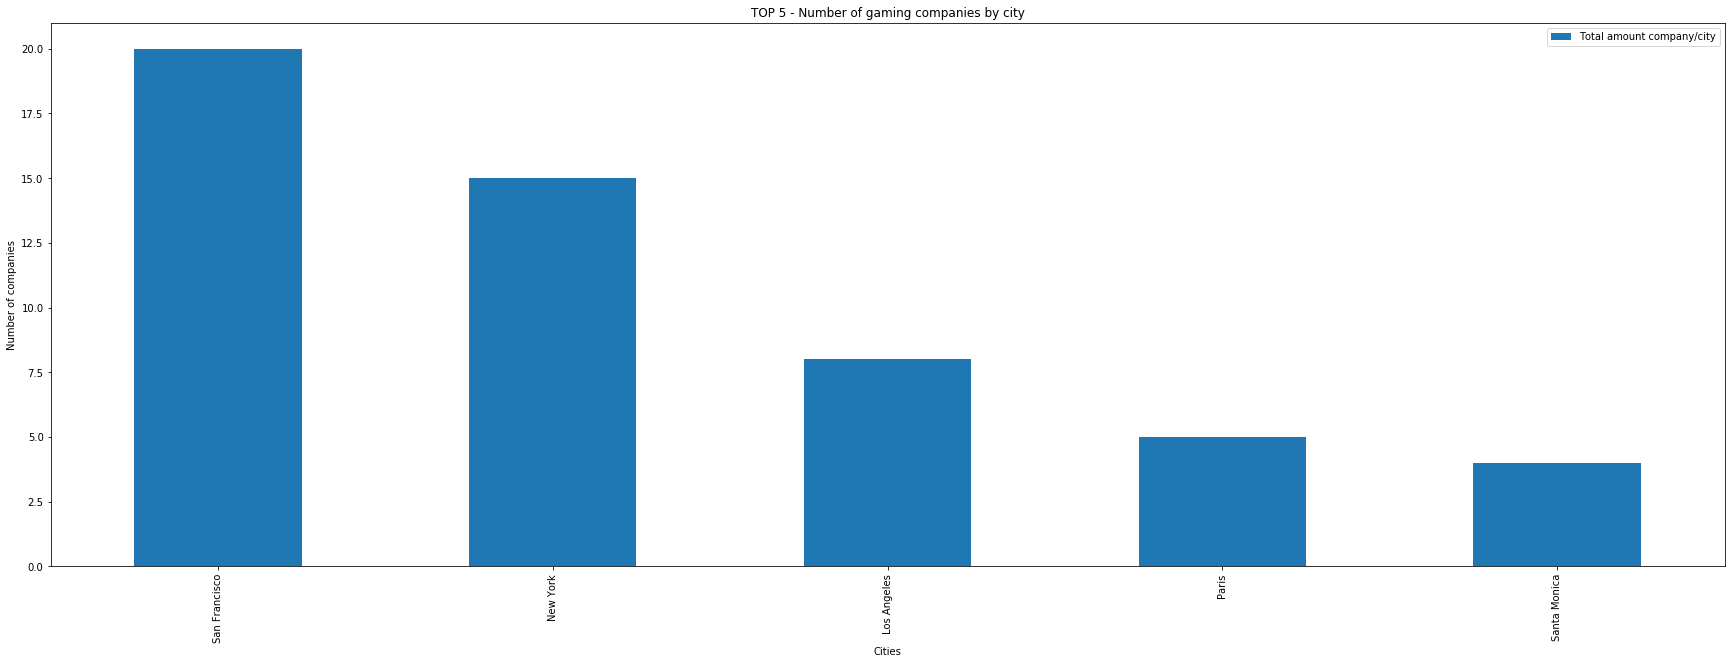

In [12]:
#TOP5 cities with more companies with 'category code' = 'video_games'

graph_df=df_companies[['city','name']]
graphic= graph_df.groupby('city').count().sort_values('name',ascending = False).head()

graphic.plot.bar(figsize=(30,10));
plt.legend(["Total amount company/city"])
plt.title("TOP 5 - Number of gaming companies by city")
plt.xlabel("Cities")
plt.ylabel("Number of companies");

## Convertig DataFrame into GeoDataFrame

In [13]:
gdf = gpd.GeoDataFrame(df_companies, geometry=gpd.points_from_xy(df_companies.longitude, df_companies.latitude))
gdf.head()

,name,category_code,number_of_employees,total_money_raised,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,geometry
0,Comcast,games_video,100000,$725M,One Comcast Center,1701 JFK Blvd,,19103,Philadelphia,PA,USA,39.952576,-75.165252,POINT (-75.16525 39.95258)
1,The Walt Disney Company,games_video,25000,$0,None,500 S. Buena Vista St.,,91521,Burbank,CA,USA,34.156802,-118.324987,POINT (-118.32499 34.15680)
2,Nintendo,games_video,5080,$0,None,None,None,None,None,None,JPN,36.204824,138.252924,POINT (138.25292 36.20482)
5,Netflix,games_video,2000,$230M,None,100 Winchester Circle,,95032,Los Gatos,CA,USA,37.251420,-121.968687,POINT (-121.96869 37.25142)
9,Kabam,games_video,650,$125M,HQ,795 Folsom Street,Suite 600,94107,San Francisco,CA,USA,37.394456,-122.078531,POINT (-122.07853 37.39446)


In [14]:
Map([Layer(gdf), size_continuous_layer(gdf, 'number_of_employees')])

## MAPS BY CITY

### GEOCODE API: 
NEEDED FUNCTION IN ORDER TO EXTRACT COORDINATES:

In [15]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }

In [16]:
sf = geocode("San Francisco, CA, USA")
sf

{'type': 'Point', 'coordinates': [-122.40438, 37.66873]}

In [17]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }

In [18]:
query = withGeoQuery(sf)

In [19]:
comp = list(db["cleancompanies"].find(query))
print(len(comp))

18


In [20]:
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

NameError: name 'ny' is not defined

In [ ]:
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

### 1 - SAN FRANCISCO

In [ ]:
start_lat = 37.66873
start_lon = -122.40438
heat_m_sf = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='lightgreen')).add_to(heat_m_sf)

In [ ]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_sf)
heat_m_sf

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='San Francisco Airport USA'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()

lat_sf_airport=(data['results'][0]['geometry']['location']['lat'])
long_sf_airport=(data['results'][0]['geometry']['location']['lng'])

In [ ]:
heat_m_sf.add_child(Marker([lat_sf_airport, long_sf_airport], icon=folium.Icon(color='lightblue')))
heat_m_sf

In [ ]:
#KM between airport & city
sf = (37.66873,-122.40438) 
airport_sf = (37.6213129,-122.3789554) 
print(great_circle(sf, airport_sf).km)

### 2 - NEW YORK

In [ ]:
ny = geocode("New York")
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

In [ ]:
start_lat = 40.689081
start_lon = -73.9586
heat_m_ny = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='red')).add_to(heat_m_ny)

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='New York Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_ny_airport=(data['results'][0]['geometry']['location']['lat'])
long_ny_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_ny_airport)
print(long_ny_airport)

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='Newark Airport USA'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_newark_airport=(data['results'][0]['geometry']['location']['lat'])
long_newark_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_newark_airport)
print(long_newark_airport)

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='LaGuardia Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_laguardia_airport=(data['results'][0]['geometry']['location']['lat'])
long_laguardia_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_laguardia_airport)
print(long_laguardia_airport)

In [ ]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_ny)

In [ ]:
heat_m_ny.add_child(Marker([lat_ny_airport, long_ny_airport], icon=folium.Icon(color='lightblue')))
heat_m_ny.add_child(Marker([lat_laguardia_airport, long_laguardia_airport], icon=folium.Icon(color='lightblue')))
heat_m_ny.add_child(Marker([lat_newark_airport,lat_newark_airport], icon=folium.Icon(color='lightblue')))

In [ ]:
#KM between airport & city
ny = (40.689081,-73.9586) 
airport_ny = (40.6413111,-73.7767901197085) 
print(great_circle(ny, airport_ny).km)

### 3 - LOS ANGELES

In [ ]:
la = geocode("Los Angeles")
la

In [ ]:
query = withGeoQuery(la)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

In [ ]:
start_lat = 34.04015
start_lon = -118.29757
heat_m_la = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='green')).add_to(heat_m_la)

In [ ]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_la)

In [25]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Los Angeles Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_la_airport=(data['results'][0]['geometry']['location']['lat'])
long_la_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_la_airport)
print(long_la_airport)

Python-dotenv could not parse statement starting at line 2


33.9415889
-118.40853


In [ ]:
la_air_long, la_air_lat = -118.4071810197085, 33.9429378802915
heat_m_la.add_child(Marker([lat_la_airport, long_la_airport], icon=folium.Icon(color='lightblue')))

In [ ]:
#KM between airport & city

la = (34.04015,-118.29757) 
airport_la = (33.9429378802915,-118.4071810197085) 
print('Km from LA to LA Airport =', great_circle(la, airport_la).km)

### 4 - PARIS

In [26]:
paris = geocode("Paris")
paris

{'type': 'Point', 'coordinates': [2.34293, 48.85717]}

In [27]:
start_lat = 48.85717
start_lon = 2.34293
heat_m_paris = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='pink')).add_to(heat_m_paris)

In [28]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_paris)

In [29]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='France Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Paris-Charles De Gaulle', 'short_name': 'Paris-Charles De Gaulle', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': 'Roissy-en-France', 'short_name': 'Roissy-en-France', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '95700', 'short_name': '95700', 'types': ['postal_code']}], 'formatted_address': 'Paris-Charles De Gaulle (CDG), 95700 Roissy-en-France, France', 'geometry': {'location': {'lat': 49.0096906, 'lng': 2.5479245}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 49.0110395802915, 'lng': 2.549273480291502}, 'southwest': {'lat': 49.0083416197085, 'lng': 2.546575519708498}}}, 'place_id': 'ChIJW89MjgM-5kcRLKZbL5jgKwQ', 'plus_code': {'compound_code': '2G5X+V5 Roissy-en-France, France', 'global_c

In [30]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Orly Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Orly Airport', 'short_name': 'Orly Airport', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': 'Orly', 'short_name': 'Orly', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '94390', 'short_name': '94390', 'types': ['postal_code']}], 'formatted_address': 'Orly Airport (ORY), 94390 Orly, France', 'geometry': {'location': {'lat': 48.7262433, 'lng': 2.3652472}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 48.7275922802915, 'lng': 2.366596180291502}, 'southwest': {'lat': 48.7248943197085, 'lng': 2.363898219708498}}}, 'place_id': 'ChIJHTtq-rF15kcRIoTbQ9feeJ0', 'plus_code': {'compound_code': 'P9G8+F3 Orly, France', 'global_code': '8FW4P9G8+F3'}, 'types': ['airport', 'establishment', 'point_of_interest']}

In [31]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Le Bourget Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Paris Airport-Le Bourget', 'short_name': 'Paris Airport-Le Bourget', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': '1', 'short_name': '1', 'types': ['street_number']}, {'long_name': 'Rue Désiré Lucca', 'short_name': 'Rue Désiré Lucca', 'types': ['route']}, {'long_name': 'Le Bourget', 'short_name': 'Le Bourget', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '93350', 'short_name': '93350', 'types': ['postal_code']}], 'formatted_address': 'Paris Airport-Le Bourget, 1 Rue Désiré Lucca, 93350 Le Bourget, France', 'geometry': {'location': {'lat': 48.9614725, 'lng': 2.437202}, 'location_type': 'ROOFTOP', 'viewport': {'northeast': {'lat': 48.9628214802915, 'lng': 2.438550980291502}, 'southwest': {'lat': 48.9601235197085, 'ln

In [32]:
paris_air_long, paris_air_lat = 2.445518380291502, 48.9574994802915
heat_m_paris=heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [33]:
paris_air_long, paris_air_lat = 2.366596180291502, 48.7275922802915
heat_m_paris=heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [34]:
paris_air_long, paris_air_lat = 2.546575519708498, 49.0083416197085
heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [35]:
#KM between airport & city - 'Paris-Charles De Gaulle'

paris = (48.85717,2.34293)
airport_paris = (48.9574994802915,2.445518380291502) 
print(great_circle(paris, airport_paris).km)

13.441591048596273


In [36]:
#KM between airport & city - 'Orly Airport'

paris = (48.85717,2.34293)
airport_paris = (48.7275922802915,2.366596180291502) 
print(great_circle(paris, airport_paris).km)

14.512328143601765


In [37]:
#KM between airport & city - 'Paris Airport-Le Bourget'

paris = (48.85717,2.34293)
airport_paris = (49.0083416197085,2.546575519708498)
print(great_circle(paris, airport_paris).km)

22.446785338050443


### 5 - SANTA MONICA

In [ ]:
sm = geocode("Santa Monica, CA, USA")
sm

In [ ]:
start_lat = 34.02401
start_lon = -118.48319
heat_m_sm = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='black')).add_to(heat_m_sm)

In [ ]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_sm)

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Santa Monica Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

In [ ]:
airport_long, airport_lat = -118.4459796197085, 34.01916328029149
heat_m_sm.add_child(Marker([airport_lat, airport_long], icon=folium.Icon(color='lightblue')))

In [ ]:
#KM between airport & city
sf = (34.02401,-118.48319) 
airport_sf = (34.01916328029149,-118.4459796197085) 
print(great_circle(sf, airport_sf).km)

In [ ]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
location="34.02401,-118.48319"
site='nursery'
data=requests.get(f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius=5000&type={site}&keyword=cruise&key={token}").json()

In [ ]:
df_nurseries_sm=pd.DataFrame(data['results'])

In [ ]:
df_nurseries_sm

In [ ]:
exapand_office_column = df_nurseries_sm[["geometry"]].apply(lambda r: r.geometry, result_type="expand", axis=1)
data_expanded_nur = pd.concat([df_nurseries_sm,exapand_office_column], axis=1)

In [ ]:
data_expanded_nur.head()

In [ ]:
exapand_loc_column = data_expanded_nur[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
data_expanded_nur_1 = pd.concat([data_expanded_nur,exapand_loc_column], axis=1)

In [ ]:
data_expanded_nur_1.to_json('sf_nurseries.json',orient='records')

In [ ]:
gdf_nursery = gpd.GeoDataFrame(data_expanded_nur_1, geometry=gpd.points_from_xy(data_expanded_nur_1.lng, data_expanded_nur_1.lat))
gdf_nursery.head()

In [ ]:
from folium.plugins import MarkerCluster
nursery = gdf_nursery[['lat', 'lng']]
print(type(nursery))
nursery

In [ ]:
nursery_group = folium.FeatureGroup(name="Demo2_Nursery")
nursery_group.add_child(MarkerCluster(locations=nursery[['lat', 'lng']]))
heat_m_sm.add_child(nursery_group)

## PUB

In [21]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
location="34.02401,-118.48319"
site='pub'
data=requests.get(f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius=5000&type={site}&keyword=cruise&key={token}").json()

Python-dotenv could not parse statement starting at line 2


In [22]:
df_pub_sm=pd.DataFrame(data['results'])

In [23]:
expand_geo_column_pub = df_pub_sm[["geometry"]].apply(lambda r: r.geometry, result_type="expand", axis=1)
data_expanded_pub = pd.concat([df_pub_sm,exapand_office_column], axis=1)

ValueError: Shape of passed values is (494, 23), indices imply (294, 23)

In [24]:
data_expanded_pub.to_json('pub_sm',orient='records')

NameError: name 'data_expanded_pub' is not defined

In [ ]:
gdf_pub = gpd.GeoDataFrame(data_expanded_nur_1, geometry=gpd.points_from_xy(data_expanded_nur_1.lng, data_expanded_nur_1.lat))

In [ ]:
from folium.plugins import MarkerCluster
pub = gdf_pub[['lat', 'lng']]
print(type(pub))
pub

In [ ]:
pub_group = folium.FeatureGroup(name="PUB4")
pub_group.add_child(MarkerCluster(location=pub[['lat','lng']]))
heat_m_sm.add_child(pub_group)